# Prevendo Notas do ENEM

O objetivo dessa análise é desenvolver um modelo que seja capaz de prever a nota no ENEM de um participante, baseado em dados socioeconômicos sobre ele.
<br><br>
O objetivo é que, a partir dessas previsões, a gente consiga analisar quais variáveis possuem maior impacto na previsão, o que pode ajudar a avaliar a necessidade do sistema de cotas.
<br><br>
Iremos julgar como injustiça um parâmetro que supostamente não deveria ser relevante para decidir a nota do participante, mas que o modelo julgou como relevante.

## Baixando dados

Os dados originais do ENEM 2022 já foram tratados para o modelo nos arquivos de tratamento.
<br><br>
Agora, os datasets de microdados e hábitos de estudo serão juntados, usando o código de inscrição dos participantes.

In [74]:
# Bibliotecas importantes
import pandas as pd
import numpy as np
import seaborn as sns

In [75]:
df_microdados = pd.read_csv("microdados_tratado.csv")
df_estudo = pd.read_csv("habitos_estudo_tratado.csv")

In [76]:
# Tamanho dos datasets originais
print(f"Tamanho Microdados: {len(df_microdados)}")
print(f"Tamanho Hábitos Estudo: {len(df_estudo)}")

Tamanho Microdados: 669781
Tamanho Hábitos Estudo: 78241


In [77]:
# Juntando datasets
df = pd.merge(df_microdados, df_estudo, on="NU_INSCRICAO")
df

,NU_INSCRICAO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESCOLA,TP_ENSINO,Q006,COR_RACA_1.0,COR_RACA_2.0,COR_RACA_3.0,COR_RACA_4.0,...,PANDEMIA_GESTAO,PANDEMIA_PRATICAS,GESTAO,PRATICAS,Q025,Q026,Q028,Q030,Q032,Q033
0,210056012033,3,0,1.0,0.0,5,True,False,False,False,...,2.25,1.583333,1.0,1.0,2,2,4,2,2,2
1,210057478691,3,0,1.0,0.0,1,False,False,True,False,...,1.50,1.500000,0.0,0.5,2,2,6,2,2,2
2,210056688095,4,1,1.0,0.0,2,False,True,False,False,...,1.00,1.000000,1.0,1.0,2,1,1,1,1,1
3,210057511905,3,0,1.0,0.0,1,False,False,True,False,...,1.25,1.583333,2.0,2.0,1,1,1,1,1,1
4,210057838909,3,0,1.0,0.0,2,False,False,True,False,...,1.00,1.166667,1.0,1.0,2,2,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21818,210057405995,3,1,0.0,0.0,5,False,False,True,False,...,1.75,2.166667,1.5,3.0,2,1,1,2,2,2
21819,210055900340,2,1,0.0,0.0,9,False,False,True,False,...,1.75,1.250000,1.0,1.5,2,2,2,2,2,2
21820,210054991409,3,1,1.0,0.0,4,True,False,False,False,...,1.00,1.000000,0.0,0.0,2,2,2,1,2,2
21821,210055081282,6,1,1.0,0.0,2,False,False,True,False,...,0.00,0.000000,0.0,0.0,2,2,2,2,1,1


In [78]:
# Quantas linhas sobrariam se removessemos NAs?
df.dropna().shape[0]

21823

In [79]:
# Quanto é esse valor, em porcentagem, em relaçao ao dataset original do ENEM 2022?
# Se for ver nos outros arquivos, o número total de candidatos é 3.476.105
TAMANHO_TOTAL = 3476105
tamanho_novo  = df.dropna().shape[0]
100 * tamanho_novo / TAMANHO_TOTAL

0.6278003685159108

In [80]:
# Retirando o NU_INSCRICAO, pois foi usado somente para juntar os datasets
df.drop("NU_INSCRICAO", axis=1, inplace=True)

Juntando os datasets, temos apenas 0,63% dos dados originais do ENEM 2022. Isso significa que a amostra que estamos lidando é de 0,63% da população total (onde a população são os participantes do ENEM 2022). Embora seja um valor relativamente baixo, ainda é possível fazer boas análises, contanto que essa amostra seja representativa. 

## Train/Test Split

In [81]:
# Criando coluna das classes (cada classe é uma faixa de notas)
from math import floor
faixa = 100
df["CLASSE_NOTA"] = np.floor(df["NOTA_FINAL"] / faixa).astype(int)
df.drop("NOTA_FINAL", axis=1, inplace=True)
df["CLASSE_NOTA"]

0        7
1        4
2        5
3        3
4        4
        ..
21818    6
21819    5
21820    4
21821    3
21822    5
Name: CLASSE_NOTA, Length: 21823, dtype: int64

In [82]:
df["CLASSE_NOTA"].value_counts()

CLASSE_NOTA
5    8548
4    7876
6    3265
3    1701
7     378
2      48
8       5
1       2
Name: count, dtype: int64

In [83]:
# Classes 1 e 8 possuem pouquissímos dados, o que atrapalha a avaliação do k-fold (por ser menor que o valor de cv escolhido, que é 5). Assim, serão removidos
df.drop(df[df["CLASSE_NOTA"] == 1].index, inplace=True)
df.drop(df[df["CLASSE_NOTA"] == 8].index, inplace=True)
df["CLASSE_NOTA"].value_counts()

CLASSE_NOTA
5    8548
4    7876
6    3265
3    1701
7     378
2      48
Name: count, dtype: int64

<Axes: xlabel='CLASSE_NOTA', ylabel='Count'>

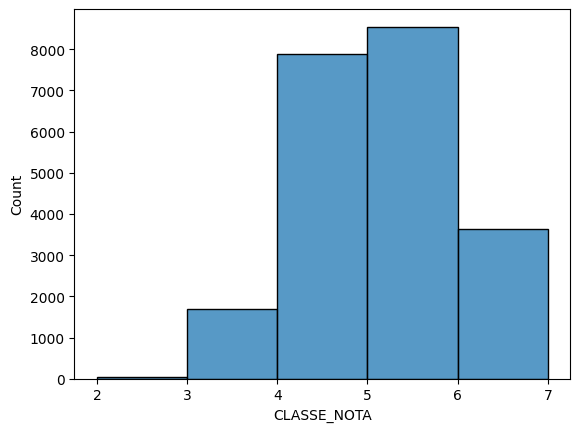

In [84]:
# Proporção das notas
import seaborn as sns
sns.histplot(x=df["CLASSE_NOTA"], binwidth=1)

In [85]:
# Fazendo split de treino/teste
# Random state fixado para constância de resultados
from sklearn.model_selection import train_test_split
X = df.drop("CLASSE_NOTA", axis=1)
Y = df["CLASSE_NOTA"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=42)

<Axes: xlabel='CLASSE_NOTA', ylabel='Count'>

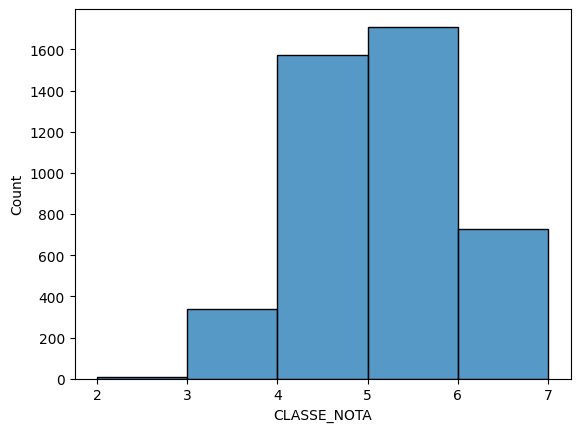

In [86]:
# Teste
import seaborn as sns
sns.histplot(x=y_test, binwidth=1)

<Axes: xlabel='CLASSE_NOTA', ylabel='Count'>

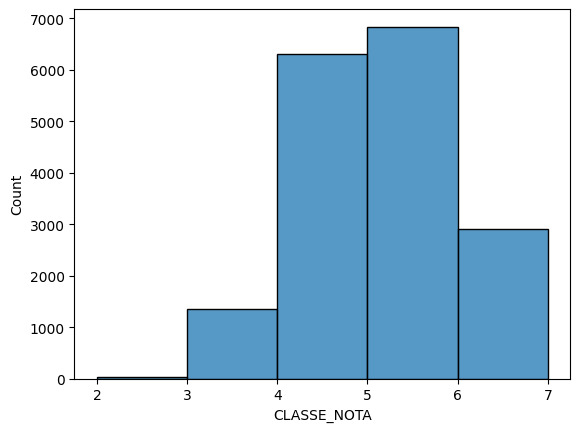

In [87]:
# Treino
import seaborn as sns
sns.histplot(x=y_train, binwidth=1)

## Testando modelos básicos

Nessa sessão, serão treinados três modelos, sem muita alteração nos seus hiperparâmetros, para ter uma noção dos resultados que podemos conseguir. Foram escolhidos os seguintes modelos: Logistic Regression, Random Forest e SVM.

In [88]:
# Para avaliar os modelos, será usado k-fold
from sklearn.model_selection import cross_val_score

In [89]:
# Regressão Logística
from sklearn.linear_model import LogisticRegression
model_logreg = LogisticRegression()
cross_val_score(model_logreg, X_train, y_train, cv=5, scoring="accuracy").mean()

/home/robertotomchak/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/robertotomchak/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

0.49558763878298595

In [90]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
model_randforest = RandomForestClassifier(n_jobs=-1)
cross_val_score(model_randforest, X_train, y_train, cv=5, scoring="accuracy").mean()

0.47965836013851415

In [91]:
# SVM
#from sklearn.svm import SVC
#model_svm = SVC()
#cross_val_score(model_svm, X_train, y_train, cv=5, scoring="accuracy").mean()

Os três modelos tiveram uma acurácisa parecida e consideravelmente baixo (um pouco abaixo de 50%), o que indica que as variáveis que temos a disposição não são suficientes para prever com precisão as notas dos participantes do ENEM.
<br><br>
Por terem tido resultados parecidos e pelo modelo de SVM ter um treinamento lento, ele será desconsiderado no restante da análise.

### Variáveis Relevantes

O modelo de RandomForest possui alta interpretabilidade, o que ajuda a entender como as variáveis impactam na previsão da nota do estudante.

In [92]:
model_randforest.fit(X_train, y_train)
features = sorted(zip(model_randforest.feature_importances_, X_train.columns), reverse=True)
for importance, feature in features:
    print(f"{feature}: {importance}")

PANDEMIA_PRATICAS: 0.11072196671273066
PANDEMIA_GESTAO: 0.08515466332998542
Q006: 0.08493167941596455
Q028: 0.07965606122123614
GESTAO: 0.07017590717989311
PRATICAS: 0.06354740898166313
Q034: 0.05009844062504065
TP_FAIXA_ETARIA: 0.049981022498533104
Q004: 0.03461413160963765
Q003: 0.034148380537317426
TP_SEXO: 0.02930856977829637
Q032: 0.028745237103366204
Q033: 0.02689580354706407
Q025: 0.024236748611338326
Q026: 0.022056204155814402
Q030: 0.021008510011806376
TP_ESCOLA: 0.020664549616284174
REGIAO_NORDESTE: 0.019843154990519713
Q001: 0.01962188268798443
REGIAO_SUDESTE: 0.018116624219160445
COR_RACA_3.0: 0.014615720988152869
COR_RACA_1.0: 0.014058213236225811
REGIAO_NORTE: 0.013289880296948968
REGIAO_CENTROOESTE: 0.012344172016392655
COR_RACA_2.0: 0.011243182931785702
Q002: 0.01098740552148192
REGIAO_SUL: 0.010900371472484193
NACIONALIDADE_1.0: 0.005093596409765097
NACIONALIDADE_2.0: 0.00449568423646546
COR_RACA_4.0: 0.004219793215732413
TP_ENSINO: 0.0021206862399049836
COR_RACA_5.0: 

In [93]:
# Mostrando apenas as mais relevantes (que estão acima da média)
media = 1 / len(X.columns)
for importance, feature in features:
    if importance > media:
        print(f"{feature}: {importance}")

PANDEMIA_PRATICAS: 0.11072196671273066
PANDEMIA_GESTAO: 0.08515466332998542
Q006: 0.08493167941596455
Q028: 0.07965606122123614
GESTAO: 0.07017590717989311
PRATICAS: 0.06354740898166313
Q034: 0.05009844062504065
TP_FAIXA_ETARIA: 0.049981022498533104
Q004: 0.03461413160963765
Q003: 0.034148380537317426


In [94]:
X_train.columns

Index(['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESCOLA', 'TP_ENSINO', 'Q006',
       'COR_RACA_1.0', 'COR_RACA_2.0', 'COR_RACA_3.0', 'COR_RACA_4.0',
       'COR_RACA_5.0', 'NACIONALIDADE_1.0', 'NACIONALIDADE_2.0',
       'NACIONALIDADE_3.0', 'NACIONALIDADE_4.0', 'REGIAO_CENTROOESTE',
       'REGIAO_NORDESTE', 'REGIAO_NORTE', 'REGIAO_SUDESTE', 'REGIAO_SUL',
       'Q001', 'Q002', 'Q003', 'Q004', 'Q034', 'PANDEMIA_GESTAO',
       'PANDEMIA_PRATICAS', 'GESTAO', 'PRATICAS', 'Q025', 'Q026', 'Q028',
       'Q030', 'Q032', 'Q033'],
      dtype='object')

In [95]:
# Soma do impacto das variáveis ligadas à pandemia
var_pandemia = ["Q001", "Q002", "Q003", "Q004", "PANDEMIA_PRATICAS", "PANDEMIA_GESTAO", "Q028"]
soma = 0
for importance, feature in features:
    if feature in var_pandemia:
        soma += importance
soma

0.37490449162037365

As duas primeiras variáveis falam sobre o estudo do participante na pandemia, tanto suas práticas (ler, fazer resumos, etc) e sua organização/gestão (fazer cronogramas, etc).
<br><br>
A Q006 indica a renda familiar do estudante.
<br><br>
A Q028 fala sobre dificuldades enfrentadas pelo participante na pandemia.
<br><br>
A gestão e as práticas do estudante parecem ser impactantes também no geral, não só na pandemia. Entretanto, é importante notar que a informação sobre elas na pandemia foi mais relevante do que no geral.
<br><br>
A questão 34 fala sobre a avaliação do aluno sobre si próprio (o quanto ele se julga preparado para a prova). Embora essa autoavaliação parece ser relevante, não é tão relevante quantos outras variáveis.
<br><br>
A faixa etária do estudante parece ser relevante também.
<br><br>
Por fim, as Questões 3 e 4 dos Hábitos de Estudo também falam sobre o estudo do aluno na pandemia (mais especificamente, sobre o modelo de ensino e a evolução do aprendizado, respectivamente). A variável sobre o sexo do participante parece ter relevância também.
<br><br>
Das 11 variáveis com relevância acima da média, 5 falavam especificamente sobre a pandemia, 6 falavam sobre sobre o estudo do aluno e 1 falava sobre a situação socioeconômica do estudante. As variáveis ligadas à pandemia somam 37,5% da importância do modelo.
<br><br><br>
Essa análise inicial indica que a pandemia pode ter tido uma grande influência nas notas dos estudantes.


## Melhorando Modelo de Random Forest

### Hiperparâmetros

Visando buscar um modelo melhor, será feito uma análise de hiperparâmetros do modelo de Random Forest.
<br><br>
A técnica utilizada aqui será o Grid Search.

In [96]:
# Profundidade máxima das árvores no modelo base
max([estimator.tree_.max_depth for estimator in model_randforest.estimators_])

44

In [97]:
# Escolha dos hiperparâmetros a serem testados
# Será variado o número de árvores e a profundidade delas
param_grid = [
    {"n_estimators": [10, 100, 250, 500], "max_depth": [2, 20, 40, 44]}
]

In [98]:
from sklearn.model_selection import GridSearchCV
model_randforest = RandomForestClassifier(n_jobs=-1)
grid_search = GridSearchCV(model_randforest, param_grid=param_grid, cv=5, scoring="accuracy", return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1),
             param_grid=[{'max_depth': [2, 20, 40, 44],
                          'n_estimators': [10, 100, 250, 500]}],
             return_train_score=True, scoring='accuracy')

In [99]:
# All scores (sorted)
cvres = grid_search.cv_results_
results = sorted(zip(cvres["mean_test_score"], cvres["params"]), reverse=True)
for score, params in results:
    print(score, params)

0.49163369745698926 {'max_depth': 20, 'n_estimators': 500}
0.4913469182728572 {'max_depth': 20, 'n_estimators': 250}
0.48865398458089937 {'max_depth': 40, 'n_estimators': 500}
0.4881954333656993 {'max_depth': 20, 'n_estimators': 100}
0.48756533993675094 {'max_depth': 44, 'n_estimators': 500}
0.4873930918555204 {'max_depth': 44, 'n_estimators': 250}
0.48676355655434894 {'max_depth': 40, 'n_estimators': 250}
0.48366883652519493 {'max_depth': 44, 'n_estimators': 100}
0.48235134307704053 {'max_depth': 40, 'n_estimators': 100}
0.4816639266423115 {'max_depth': 2, 'n_estimators': 100}
0.4782260072770013 {'max_depth': 2, 'n_estimators': 500}
0.4777106419372286 {'max_depth': 2, 'n_estimators': 250}
0.46825584248977525 {'max_depth': 2, 'n_estimators': 10}
0.4539305574137016 {'max_depth': 20, 'n_estimators': 10}
0.4443039202730887 {'max_depth': 44, 'n_estimators': 10}
0.43742781889410265 {'max_depth': 40, 'n_estimators': 10}


Note que houve pouca diferença entre os scores de cada modelo, o que significa que alterar os hiperparâmetros não leva a grande melhora no modelo nesse problema. Isso indica que ou o modelo de Random Forest não modela bem o problema, ou as variáveis que temos não são suficientes para criar boas previsões.

In [100]:
# Analisando os parâmetros mais importantes no melhor modelo obtido
features = sorted(zip(grid_search.best_estimator_.feature_importances_, X_train.columns), reverse=True)
media = 1 / len(X.columns)
for importance, feature in features:
    if importance > media:
        print(f"{feature}: {importance}")

PANDEMIA_PRATICAS: 0.10578840608747425
Q006: 0.08660687804513824
Q028: 0.08390241752965628
PANDEMIA_GESTAO: 0.08285397066283365
GESTAO: 0.06781002396180673
PRATICAS: 0.06231144472311753
TP_FAIXA_ETARIA: 0.05000060999904232
Q034: 0.04852343908229456
Q003: 0.03555165063026845
Q004: 0.03470545621125042


In [101]:
# Soma do impacto das variáveis ligadas à pandemia
var_pandemia = ["Q001", "Q002", "Q003", "Q004", "PANDEMIA_PRATICAS", "PANDEMIA_GESTAO", "Q028"]
soma = 0
for importance, feature in features:
    if feature in var_pandemia:
        soma += importance
soma

0.3751254886460258

Houve pouca diferença nas variáveis julgadas relevantes entre o melhor modelo da Grid Search e o modelo básico. As variáveis continuaram as mesmas, o que mudou foi a ordem de algumas. A relevância das variáveis ligadas à pandemia continuou praticamente a mesma.

### Testando um Gradient Booting Classifier

In [103]:
# Modelo do Scikit Learn
from sklearn.ensemble import GradientBoostingClassifier
model_gbc = GradientBoostingClassifier()
cross_val_score(model_gbc, X_train, y_train, cv=5, scoring="accuracy").mean()

0.501203159331527

In [104]:
import xgboost
xgb_reg = xgboost.XGBClassifier()

ModuleNotFoundError: No module named 'xgboost'